# Focal Operations with RastrFrames Notebook

## Setup Spark Environment

In [1]:
import pyrasterframes
from pyrasterframes.utils import create_rf_spark_session
import pyrasterframes.rf_ipython  # enables nicer visualizations of pandas DF
from pyrasterframes.rasterfunctions import *
import pyspark.sql.functions as F

In [2]:
spark = create_rf_spark_session()

### Get a PySpark DataFrame from elevation raster

Read a single scene of elevation into DataFrame or raster tiles.
Each tile overlaps its neighbor by "buffer_size" of pixels, providing focal operations neighbor information around tile edges.
You can configure the default size of these tiles, by passing a tuple of desired columns and rows as: `raster(uri, tile_dimensions=(96, 96))`. The default is `(256, 256)`

In [3]:
uri = 'https://geotrellis-demo.s3.us-east-1.amazonaws.com/cogs/harrisburg-pa/elevation.tif'
df = spark.read.raster(uri, tile_dimensions=(512, 512), buffer_size=2)

In [4]:
df.printSchema()

root
 |-- proj_raster_path: string (nullable = false)
 |-- proj_raster: struct (nullable = true)
 |    |-- tile_context: struct (nullable = true)
 |    |    |-- extent: struct (nullable = false)
 |    |    |    |-- xmin: double (nullable = false)
 |    |    |    |-- ymin: double (nullable = false)
 |    |    |    |-- xmax: double (nullable = false)
 |    |    |    |-- ymax: double (nullable = false)
 |    |    |-- crs: struct (nullable = false)
 |    |    |    |-- crsProj4: string (nullable = false)
 |    |-- tile: tile (nullable = false)



The extent struct tells us where in the [CRS](https://spatialreference.org/ref/sr-org/6842/) the tile data covers. The granule is split into arbitrary sized chunks. Each row is a different chunk. Let's see how many.

In [5]:
df.count()

81

## Focal Operations
Additional transformations are complished through use of column functions.
The functions used here are mapped to their Scala implementation and applied per row.
For each row the source elevation data is fetched only once before it's used as input.

DataFrame[rf_crs(proj_raster): struct<crsProj4:string>, rf_extent(proj_raster): struct<xmin:double,ymin:double,xmax:double,ymax:double>, rf_aspect(proj_raster): struct<tile_context:struct<extent:struct<xmin:double,ymin:double,xmax:double,ymax:double>,crs:struct<crsProj4:string>>,tile:udt>, rf_slope(proj_raster): struct<tile_context:struct<extent:struct<xmin:double,ymin:double,xmax:double,ymax:double>,crs:struct<crsProj4:string>>,tile:udt>, rf_hillshade(proj_raster): struct<tile_context:struct<extent:struct<xmin:double,ymin:double,xmax:double,ymax:double>,crs:struct<crsProj4:string>>,tile:udt>]
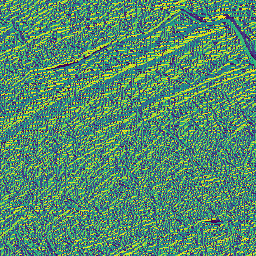
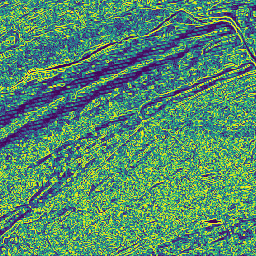
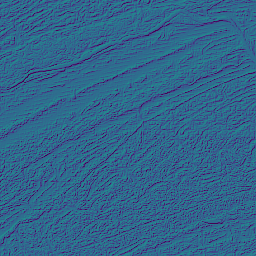
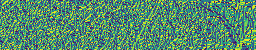
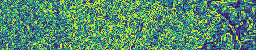
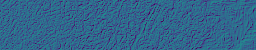
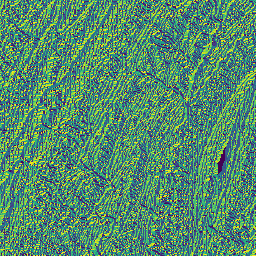
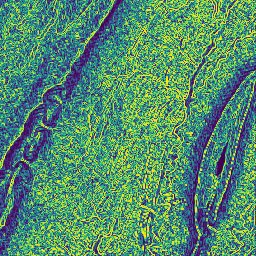
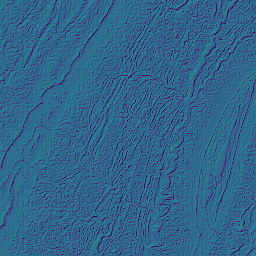
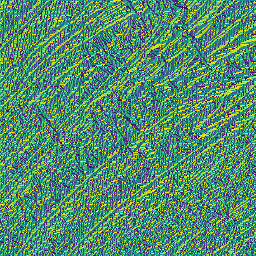
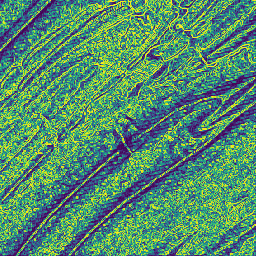
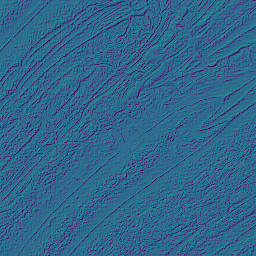
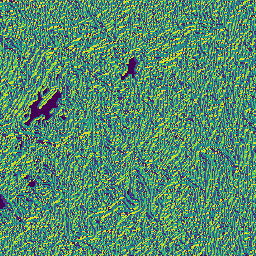
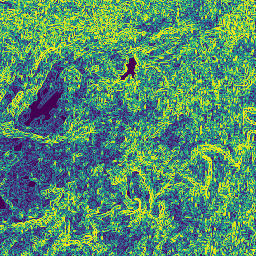
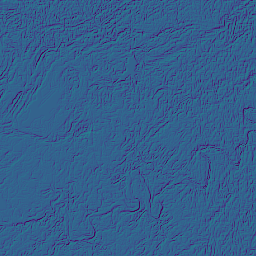

In [7]:
df.select(
    rf_crs(df.proj_raster), 
    rf_extent(df.proj_raster), 
    rf_aspect(df.proj_raster), 
    rf_slope(df.proj_raster, z_factor=1), 
    rf_hillshade(df.proj_raster, azimuth=315, altitude=45, z_factor=1))